In [2]:
import torch 
import matplotlib.pyplot as plt 
#%matplotlib inline
import numpy as np
from bindsnet.network import Network
from bindsnet.network.nodes import Input, LIFNodes, AdaptiveLIFNodes
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor
from bindsnet.analysis.plotting import plot_spikes, plot_voltages, plot_weights
from bindsnet.learning import PostPre
from bindsnet.analysis.visualization import summary, plot_spike_trains_for_example, plot_voltage
from bindsnet import encoding



In [22]:
#define the helper's function

def loss_output(y,a_out):
    '''
    calculate the objective/Loss function
    at the last layer
    output : Loss tensor
    :param y (tensor): target label : 
    :param a_out (tensor): spike activity at the output layer
    '''
    o_de = 1 if (torch.max(torch.sum(a_out,dim=0))==0) else torch.max(torch.sum(a_out,dim=0))
    #o = torch.sum(a_out,dim=0) / torch.max(torch.sum(a_out,dim=0))    
    o = torch.sum(a_out,dim=0) / o_de   
    Loss = 0.5 * torch.pow(torch.norm(o - y),2)
    return Loss

def error_backprop_out(net,y,a_out):
    '''
    calculate the error at the output layer
    output : error tensor for each neuron in the layer
    input : net, network object
    input : y , target label
    input : a_out, spike activity at the output layer
    '''
    vth = net.layers["C"].thresh
    o_de = 1 if (torch.max(torch.sum(a_out,dim=0))==0) else torch.max(torch.sum(a_out,dim=0))
    #o_vec = torch.sum(a_out,dim=0) / torch.max(torch.sum(a_out,dim=0))
    o_vec = torch.sum(a_out,dim=0) / o_de
    #denom = 1 if (np.sqrt(torch.count_nonzero(o_vec - y)) == 0) else np.sqrt(torch.count_nonzero(o_vec - y))
    denom = np.sqrt(torch.count_nonzero(o_vec - y))
    #delta_Loss = (o_vec - y) / (denom +1)
    delta_Loss = (o_vec - y) / vth
    return delta_Loss


def error_backprop(net,a_hidden,a_out,deltai_nxt):
    '''
    calculate the backprop error for each layer except output layer
    output : the error backprop tensor with dimension 1 x Number of neurons in that layer
    :param : net, network object
    :input : input data
    :a_hidden : spike activity output at the hidden layer
    :a_out : spike activit output at the output/last layer
    :deltai_nxt : backprop error from the next layer
    '''
    w = list(net.parameters())
    wij = w[2]          #get the weight of the hidden layer
    Vth = net.layers["B"].thresh
    M = net.layers["B"].n#total synapses in the next layer
    m = torch.sum(a_out,dim=0).nonzero()#vector of active synapses in the next layer  
    n = torch.sum(a_hidden,dim=0).nonzero() #vector of active neuron in the next layer
    #n = 1 if (torch.sum(a_hidden,dim=0).nonzero()==0) else torch.sum(a_hidden,dim=0).nonzero()
    g_i   = 1 / Vth
    g_bar = np.sqrt((1/(1+len(n))) * torch.sum(torch.pow(g_i[n],2)))
    deltai = (g_i / g_bar) * np.sqrt(M/(1+len(m))) * (wij @ deltai_nxt)
    return deltai
    #return g_bar

def aux_spike_activity(spike, ref_spike,tmp = 100,T=350,isPlot = True):
    '''
    calculate the continous real value spike activity based on the equation 4
    from paper Lee.et.al (2016)
    output : tensor/vector of accumulated effects of spike at the final observation time T
    input  : spike, spike activity representd in 1 or 0
    input  : ref_spike, the reference function to save computational time
    input  : tmp, time constant of decaying spike signal
    input  : T, observation time
    '''
    dt = torch.linspace(0,T-1,T) #the time axis
    xk   = torch.zeros(spike.shape) #variable to store continous real value of accummulated. spike signal    
    
    """ if (ref_spike == None):
        y = torch.exp(-dt/tmp)
    else:
        y = ref_spike    """
    y = ref_spike
    sidx = (spike).nonzero().numpy() #get the index of the spike

    # plot the binary spike activity
    if isPlot:        
        spikes = {"A":spike}
        plt.figure()
        plot_spikes(spikes)

    # calculate the accumulated spike activity    
    for id,val in enumerate(sidx):
        if val[0]==0:
            xk[:,val[1]] = np.add(xk[:,val[1]],y)
        else:
            xk[:,val[1]] = np.add(xk[:,val[1]],[*np.zeros(val[0]),*y[0:-val[0]]])

    # plot the spike signal
    if isPlot:      
        plt.figure(figsize=[10,5])
        plt.plot(dt,xk)
        plt.title("Accumulated spike activity")
        plt.xlabel("Time Steps")
        #put some legend :)
        list_legend = []
        for i in range(spike.size(1)):
            list_legend.append('neuron %s'%i)
        plt.legend((list_legend),loc='best')
    # return the last value of accum spike activity    
    return xk[-1,:]


    
def delta_weight(etaw,N,m,deltai,xj):
    '''
    calculate the delta weights in each layer
    output : the vector of weight of each layer
    input : etaw, learning rate
    input : N, total neuron in layer
    input : m, total of active synapses in layer
    input : deltai, vector of error backprop
    input : xj,vector of effective input spike activity
    '''
    di = torch.reshape(deltai,[1,len(deltai)])
    #x_j = torch.sum(xj,dim=0)
    x_j = xj.reshape([len(xj),1])
    return -etaw * np.sqrt(N/(1+m)) * di * x_j

def delta_thrs(etath,N,m,M,deltai,ai):
    '''
    calculate the delta threshold in each neuron in layer
    output : the vector of voltage threshold of each layer
    input : etath, learning rate
    input : N, total neuron in layer
    input : m, total of active synapses in layer
    input : M, total synapses in the layer
    input : deltai, vector of error backprop
    input : ai,vector of effective output spike activity
    '''
    #di  = torch.reshape(deltai,[1,len(deltai)])
    #a_i = torch.sum(ai,dim=0)
    #a_i = a_i.reshape([len(a_i),1])
    return -etath * np.sqrt(N/((1+m)*M)) * deltai * ai

def calculate_gradient(net,etaw,etath,di_out,di_hid,a_out,a_hid,x_out,x_hid):
    '''
    calculate the gradient of weights and voltage threshold
    output : tensor to update the weights and thresholds
    input : net, network object 
    input : 
    input :
    input :
    '''
    N_out   = net.layers["C"].n#total neuron in the output layer
    N_hid   = net.layers["B"].n#total neuron in the hidden layer
    M_out   = N_hid #total synapses in the output layer
    M_hid   = net.layers["A"].n#total synapses in the hidden layer

    m_out   = len(torch.sum(a_out,dim=0).nonzero())#total active synapses in the output layer
    m_hid   = len(torch.sum(a_hidden,dim=0).nonzero())#total active synapses in the hidden layer


    #1. weight in the last layer
    dwout = delta_weight(etaw,N_out,m_out,di_out,x_out)    
    
    #2. weight in the middle layer
    dwhid = delta_weight(etaw,N_hid,m_hid,di_hid,x_hid)
    
    #3. threshold in the last layer
    d_thout = delta_thrs(etath,N_out,m_out,M_out,di_out,a_out)
    
    #4. threshold in the middle layer
    d_thid = delta_thrs(etath,N_hid,m_hid,M_hid,di_hid,a_hid)

    #store the information gradient in the dictionary
    params = {"wo" : dwout,
              "wh" : dwhid,
              "to" : d_thout,
              "th" : d_thid
            }
    
    return params

def accumulate_paramaters(params_tmp,params):
    '''
    add two parameters
    output new parameters
    input params
    input params_tmp
    '''

    var1 = params_tmp["wo"] + params["wo"]
    var2 = params_tmp["wh"] + params["wh"]
    var3 = params_tmp["to"] + params["to"]
    var4 = params_tmp["th"] + params["th"]

    param_out = {
                "wo":var1,
                "wh":var2,
                "to":var3,
                "th":var4
    }
    return param_out


def update_weigth_threshold(net,params):
    '''
    update the weights and voltage threshold parameters
    input : net , network object
    input : params, dictionary containing gradient of weights and thresholds
    '''

    w   = list(net.parameters())
    vth = [net.layers["B"].thresh,net.layers["C"].thresh]

    dwout = params["wo"]
    dwhid = params["wh"]
    d_thout = params["to"]
    d_thid = params["th"]


    w[2].add_(dwout) #update the weights in the last layer
    w[0].add_(dwhid) #update the weights in the hidden layer 
    vth[1].add_(d_thout) #update the threshold in the last layer
    vth[0].add_(d_thid) #update the threshold in the hidden layer



def update_params(net,etaw,etath,di_out,di_hid,a_out,a_hid,x_out,x_hid,ref_spike,tmp,T):
    '''torch.max(torch.sum(a_out,dim=0))
    calculate the delta weights and thresholds and update its value
    :input : net
    :
    '''
    N_out   = net.layers["C"].n#total neuron in the output layer
    N_hid   = net.layers["B"].n#total neuron in the hidden layer
    M_out   = N_hid #total synapses in the output layer
    M_hid   = net.layers["A"].n#total synapses in the hidden layer

    m_out   = len(torch.sum(a_out,dim=0).nonzero())#total active synapses in the output layer
    m_hid   = len(torch.sum(a_hidden,dim=0).nonzero())#total active synapses in the hidden layer

    w   = list(net.parameters())
    vth = [net.layers["B"].thresh,net.layers["C"].thresh]
    #calculate the auxillary spike activity

    x_out_aux = aux_spike_activity(x_out, ref_spike,tmp = tmp,T=T,isPlot = False)
    x_hid_aux = aux_spike_activity(x_hid, ref_spike,tmp = tmp,T=T,isPlot = False)
    a_out_aux = aux_spike_activity(a_out, ref_spike,tmp = tmp,T=T,isPlot = False)
    a_hid_aux = aux_spike_activity(a_hid, ref_spike,tmp = tmp,T=T,isPlot = False)
    #1. weight in the last layer
    dwout = delta_weight(etaw,N_out,m_out,di_out,x_out_aux)    
    w[2].add_(dwout) #update the parameters
    #2. weight in the middle layer
    dwhid = delta_weight(etaw,N_hid,m_hid,di_hid,x_hid_aux)
    w[0].add_(dwhid) #update the parameters
    #print("last layer delta w ",dwout)
    
    #3. threshold in the last layer
    d_thout = delta_thrs(etath,N_out,m_out,M_out,di_out,a_out_aux)
    vth[1].add_(d_thout)
    #4. threshold in the middle layer
    d_thid = delta_thrs(etath,N_hid,m_hid,M_hid,di_hid,a_hid_aux)
    vth[0].add_(d_thid)

    
    

In [23]:
#simulation time
time = 350 #in millisecond
batch = 4 #batch size
decay_time = 150 #wait till the membrane voltage to decay
#other parameters according Lee et.al(2016)
alpha = [8 ,2]
beta  = 10
lamda = 0.002
rho   = 0.0001
eta_w  = 0.02        #learning rate for synaptic weight
eta_th = 1 * eta_w  #learning rate for voltage threshold
T_ref = 1               #refractory period
t_mp  = 20            #decay time
v_rest = -65          #default neuron rest voltage
v_thresh   = -52          #default neuron threshold voltage

#create the network
network = Network()
#create and add input, output layers

#voltage threshold as a vector 
# the value corresponds to every vth in each node
nodes = [20, 40, 4] #number of nodes in each layer

#initialize the voltage threshold
vth = [alpha[0]*np.sqrt(3.0/nodes[0]), alpha[1]*np.sqrt(3.0/nodes[1])]


thres1 = (v_rest+ vth[0]) + torch.zeros(1,nodes[1])
thres2 = (v_rest+vth[1]) + torch.zeros(1,nodes[2])

source_layer = Input(n=nodes[0],traces=True)
hidden_layer = LIFNodes(n=nodes[1],trace=True,refrac=T_ref,thresh=thres1.squeeze(),tc_decay=t_mp,lbound=v_rest - vth[0])
target_layer = LIFNodes(n=nodes[2],traces=True,refrac=T_ref,thresh=thres2.squeeze(),tc_decay=t_mp,lbound=v_rest - vth[1])
#target_layer = AdaptiveLIFNodes(n=4, traces=True,refrac=1,thresh=)

network.add_layer(
    layer = source_layer, name="A"
)
network.add_layer(
    layer = hidden_layer, name="B"
)
network.add_layer(
    layer = target_layer, name="C"
)

#print("voltage threshold in output layer neuron "+str(network.layers["C"].thresh))
#print("voltage threshold in hidden layer neuron "+str(network.layers["B"].thresh))
#create a connection between input and hidden layers
forward_connection1 = Connection(
    source = source_layer,
    target= hidden_layer,
    #weight initialization according to Lee et.al
    #w=0.05 + 0.1 * torch.randn(source_layer.n, hidden_layer.n),
    w = (np.sqrt(3.0/source_layer.n)) - 2*np.sqrt(3.0/source_layer.n)*torch.rand(source_layer.n, hidden_layer.n),
)

network.add_connection(
    connection=forward_connection1, source="A", target="B"
)

#create a connection between hidden layer and output layer
forward_connection2 = Connection(
    source = hidden_layer,
    target = target_layer,
    #weight initialization according to Lee et.al
    #w=0.05 + 0.1 * torch.randn(hidden_layer.n, target_layer.n),
    w = (np.sqrt(3.0/hidden_layer.n)) - 2*np.sqrt(3.0/hidden_layer.n)*torch.rand(hidden_layer.n, target_layer.n),
    
)

network.add_connection(
    connection=forward_connection2, source="B", target="C"
)

#create a recurrent connection in output layer
# Winner take all circuit
recurrent_connection = Connection(
    source = target_layer,
    target= target_layer,
    #w = 0.001 * (torch.eye(target_layer.n)-1),
    w = 0.6 * (torch.eye(target_layer.n)-1),
)

network.add_connection(
    connection=recurrent_connection, source="C", target="C"
)

#create and add input and output layer monitor
source_monitor = Monitor(
    obj = source_layer,
    state_vars = ("s",), #record spikes and voltages
    time = time , 
)

hidden_monitor = Monitor(
    obj = hidden_layer,
    state_vars=("s","v"),
    time = time ,
)

target_monitor = Monitor(
    obj = target_layer,
    state_vars= ("s", "v"),
    time = time ,
)

network.add_monitor(monitor=source_monitor, name="A")
network.add_monitor(monitor=hidden_monitor, name="B")
network.add_monitor(monitor=target_monitor, name="C")
#print th network summary
print(summary(network))

         NETWORK SUMMARY
         batch size:1
    ··········································
    Layer: 'A' (trainable)
   20 neurons [20]
       ·connected to 'B' by 800 synapses
    ··········································
    Layer: 'B' (trainable)
   40 neurons [40]
       ·connected to 'C' by 160 synapses
    ··········································
    Layer: 'C' (trainable)
   4 neurons [4]
       ·connected to 'C' by 16 synapses
Total neurons: 64 (64 trainable)
Total synapses weights: 976 (976 trainable)


In [24]:
#investigate the weight in forward and recurrent connection
w1 = forward_connection1.w
w2 = forward_connection2.w
k1 = recurrent_connection.w 
vth1 = network.layers["B"].thresh
vth2 = network.layers["C"].thresh
print("max and min of 1st forward connection weights"+str(torch.max(w1))+" "+str(torch.min(w1)))
print("max and min of 2nd forward connection weights"+str(torch.max(w2))+" "+str(torch.min(w2)))
print("max and min of recurrent weights "+str(torch.max(k1))+" "+str(torch.min(k1)))
print("voltage threshold hidden layer",vth1)
print("voltage threshold output layer",vth2)

max and min of 1st forward connection weightstensor(0.3854) tensor(-0.3849)
max and min of 2nd forward connection weightstensor(0.2707) tensor(-0.2729)
max and min of recurrent weights tensor(0.) tensor(-0.6000)
voltage threshold hidden layer tensor([-61.9016, -61.9016, -61.9016, -61.9016, -61.9016, -61.9016, -61.9016,
        -61.9016, -61.9016, -61.9016, -61.9016, -61.9016, -61.9016, -61.9016,
        -61.9016, -61.9016, -61.9016, -61.9016, -61.9016, -61.9016, -61.9016,
        -61.9016, -61.9016, -61.9016, -61.9016, -61.9016, -61.9016, -61.9016,
        -61.9016, -61.9016, -61.9016, -61.9016, -61.9016, -61.9016, -61.9016,
        -61.9016, -61.9016, -61.9016, -61.9016, -61.9016])
voltage threshold output layer tensor([-64.4523, -64.4523, -64.4523, -64.4523])


In [25]:
#check wheter or not the weigths satisfy the equation 11
print(forward_connection2.w)#
print(torch.sum(torch.pow((forward_connection2.w),2),dim=0))

Parameter containing:
tensor([[-0.1955,  0.1700,  0.0214, -0.0365],
        [ 0.0149, -0.1010,  0.0556,  0.0246],
        [ 0.0371, -0.0718,  0.1732, -0.0293],
        [-0.0947,  0.2312, -0.2437, -0.2173],
        [ 0.1177,  0.1241,  0.1077,  0.2317],
        [ 0.2041, -0.1786,  0.2162, -0.1536],
        [-0.1359,  0.1995,  0.1732,  0.1650],
        [ 0.1813, -0.1906, -0.2673,  0.0205],
        [ 0.0813,  0.0601,  0.0424,  0.1626],
        [-0.2149, -0.0748,  0.0063,  0.1560],
        [ 0.0537,  0.1894,  0.0904,  0.0677],
        [-0.2351, -0.2681,  0.0661, -0.2197],
        [ 0.1928, -0.0159, -0.1897,  0.0135],
        [ 0.1866, -0.0719,  0.1052,  0.1846],
        [ 0.0174,  0.2002,  0.2707,  0.0735],
        [-0.0511,  0.0430,  0.2443,  0.1900],
        [ 0.1481,  0.1516, -0.2729, -0.0957],
        [ 0.1278,  0.2535, -0.1034, -0.0781],
        [ 0.2501, -0.2302, -0.2119,  0.0668],
        [-0.1680,  0.1773, -0.2665, -0.0039],
        [-0.1060,  0.0956,  0.0959,  0.0483],
        [ 0.

Target labels  tensor([[0, 0, 0, 1],
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1]])


<Figure size 432x288 with 0 Axes>

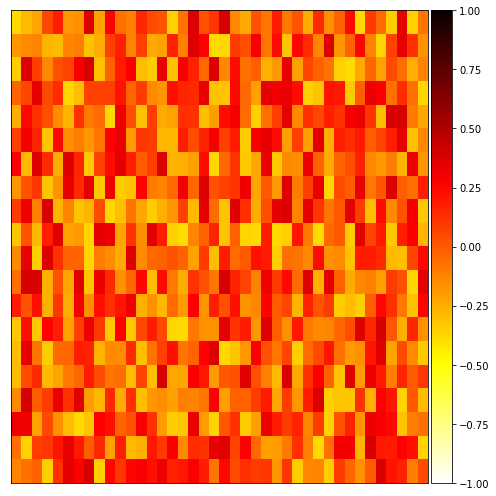

<Figure size 432x288 with 0 Axes>

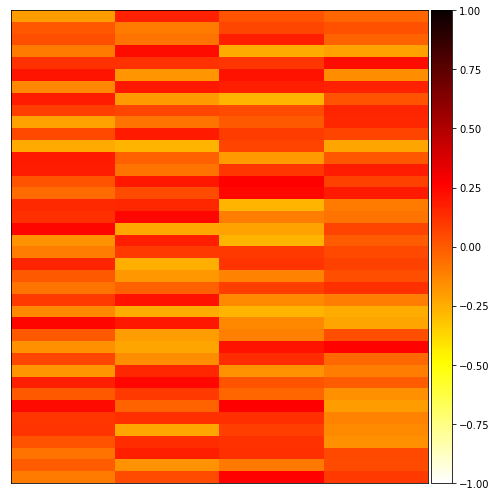

<Figure size 432x288 with 0 Axes>

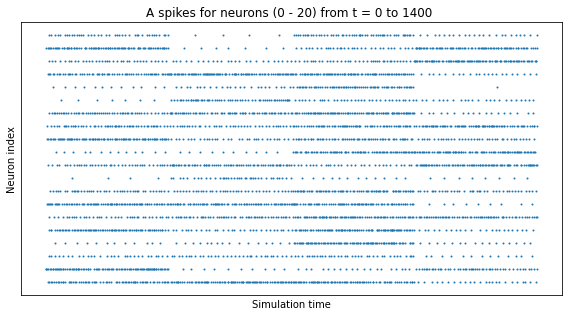

In [27]:
#create input spike data, where each spike is distributed according bernoulli
#input_data = torch.bernoulli(0.1 * torch.ones(time, source_layer.n)).byte()
#inputs = {"A":input_data}

#input_rates = spike_rate * torch.rand(source_layer.n)  # Generate random Poisson rates for N input neurons.
#input_data= encoding.poisson(datum=input_rates, time=time * batch)  # Encode input as time ms Poisson spike trains.
#inputs = {"A":input_data}

spike_rate = 250 #maximum spike rate in hz
input_data = torch.zeros(time * batch , nodes[0])
for j in range(batch):
    input_rates = spike_rate * torch.rand(source_layer.n)
    input_data[j*time:(j*time)+time,:]= encoding.poisson(datum=input_rates, time=time)  

inputs = {"A":input_data}


vary = torch.randint(low=0,high=target_layer.n,size=[batch])
if batch == 1:
    y = torch.tensor([0, 1, 0, 0],dtype=torch.uint8) #target label
else:
    y = torch.nn.functional.one_hot(vary)

print("Target labels ",y)

#plot the input train spike

plt.ioff()
plt.figure()
plot_spikes(inputs)
plt.show()
plt.figure()
plot_weights(forward_connection1.w,wmin=-1,figsize=[7,7])
plt.figure()
plot_weights(forward_connection2.w,wmin=-1,figsize=[7,7])


In [28]:
#begin the training procedure

#loop for 150 epochs
epochs = 50
L = torch.zeros(epochs) #store in the vector
l = torch.zeros(batch)
plot_train = False
y_pred = torch.zeros(batch,nodes[2])

dt = torch.linspace(0,time-1,time) #the time axis
ref_spike = torch.exp(-dt/t_mp)

for i in range(epochs): #loop for each epoch     
    for j in range(batch): #loop for each training sample in a batch
        #1. run forward propagation 
        inputs = {"A":input_data[j*time:(j*time)+time,:]}
        network.run(inputs=inputs,time=time)
        #1.1 obtain the spike activity in each nodes of every layer
        #x -> 
        spikes = {
        "A" : source_monitor.get("s"),
        "B" : hidden_monitor.get("s"),
        "C" : target_monitor.get("s")
        }

        voltages = {"B": hidden_monitor.get("v"),
                    "C": target_monitor.get("v")
        }
        
        #plot the spikes and voltages
        
        if plot_train:
            plt.ioff()
            plt.figure()
            plot_spikes(spikes)
            plt.figure()
            plot_voltages(voltages, plot_type="line")
            plt.show()
        #end of the plots
        
        a_hidden = spikes["B"].squeeze().float() #get the spike activity at the hidden layer
        a_out    = spikes["C"].squeeze().float() #get the spike activity at the output layer   
        #a_hidden  = voltages["B"].squeeze() #get the spike voltage activity at the hidden layer
        #a_out = voltages["C"].squeeze() #get the spike voltage activity at the output layer

        #save the spike activity value
        y_pred[j,:] = torch.sum(a_out,dim=0)
        
        print(torch.sum(a_out,dim=0)) #print the spike's output activity
        #print(torch.sum(a_hidden,dim=0)) #print the spike's hidden activity

        x_hidden = inputs["A"].squeeze()#input_data
        x_out    = a_hidden

        #2. calculate and keep track the loss
        if (batch==1): #if the only one training sample used
            l[j] = loss_output(y,a_out)       #y[j,:] 

            delta_i_out    =  error_backprop_out(network,y,a_out)#y[j,:]
        else: #multiple training sample in  a batch
            l[j] = loss_output(y[j,:],a_out)       

            delta_i_out    =  error_backprop_out(network,y[j,:],a_out)
        
        #3.propagate the error backprop
        
        delta_i_hid    =  error_backprop(network,a_hidden,a_out,delta_i_out)    
        #print the delta i
        #print(delta_i_out)
        #print(delta_i_hid)
        
        #4.update the paramaters (weight & threshold)
        update_params(network,eta_w,eta_th,delta_i_out,delta_i_hid,a_out,a_hidden,x_out,x_hidden,ref_spike,t_mp,time)
        #print the weight
        #print(forward_connection2.w)
        #print(network.layers["B"].thresh)

        #4. calculate the gradient of weigth and threshold
        #params_tmp = calculate_gradient(network,eta_w,eta_th,delta_i_out,delta_i_hid,a_out,a_hidden,x_out,x_hidden)
        #params = accumulate_paramaters(params_tmp,params)

        #5.reset the membrane potential in the network
        network.layers["C"].reset_state_variables()
        network.layers["B"].reset_state_variables()

        #print(network.layers["C"].thresh)
        #print(network.layers["B"].v)        
    
    #print(network.layers["C"].thresh)
    #print(network.layers["B"].thresh)
    #update the parameters of weight and voltage threshold
    #update_weigth_threshold(network,params)

    L[i] = torch.sum(l)
    print("vector l",l)
    print("epochs , loss : ",i,L[i])
    if L[i] < 0.01: #if the loss is less than specified number
            break #stop the loop



tensor([ 0., 12.,  1.,  0.])
tensor([2., 0., 0., 0.])
tensor([22.,  0.,  0.,  0.])
tensor([6., 0., 0., 0.])
vector l tensor([1.0035, 0.0000, 1.0000, 1.0000])
epochs , loss :  0 tensor(3.0035)
tensor([ 0., 14.,  2.,  0.])
tensor([1., 0., 0., 0.])
tensor([22.,  1.,  0.,  0.])
tensor([5., 1., 0., 0.])
vector l tensor([1.0102, 0.0000, 0.9556, 1.0200])
epochs , loss :  1 tensor(2.9858)
tensor([ 0., 12.,  2.,  0.])
tensor([0., 0., 0., 0.])
tensor([21.,  1.,  0.,  0.])
tensor([3., 0., 0., 0.])
vector l tensor([1.0139, 0.5000, 0.9535, 1.0000])
epochs , loss :  2 tensor(3.4674)
tensor([ 0., 13.,  2.,  0.])
tensor([0., 0., 0., 0.])
tensor([19.,  1.,  0.,  0.])
tensor([4., 0., 0., 0.])
vector l tensor([1.0118, 0.5000, 0.9488, 1.0000])
epochs , loss :  3 tensor(3.4606)
tensor([ 0., 10.,  2.,  2.])
tensor([1., 0., 0., 0.])
tensor([17.,  0.,  0.,  0.])
tensor([1., 0., 0., 0.])
vector l tensor([0.8400, 0.0000, 1.0000, 1.0000])
epochs , loss :  4 tensor(2.8400)
tensor([0., 4., 9., 2.])
tensor([0., 0.,

In [29]:
print("output spike activity")
print(y_pred.int())
print("output spike activity shifted")
print(np.roll(y_pred.int(),shift=-1,axis=0))
print("target label ")
print(y)
#print(a_out.shape)


output spike activity
tensor([[ 0,  1,  1, 11],
        [ 1,  0,  0,  0],
        [ 1,  9,  0,  0],
        [ 0,  0,  0,  2]], dtype=torch.int32)
output spike activity shifted
[[ 1  0  0  0]
 [ 1  9  0  0]
 [ 0  0  0  2]
 [ 0  1  1 11]]
target label 
tensor([[0, 0, 0, 1],
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1]])


In [30]:
#run the final prediction
y_pred_run = torch.zeros(batch,nodes[2])
for j in range(batch):
    inputs = {"A":input_data[j*time:(j*time)+time,:]}
    network.run(inputs=inputs,time=time)
    a_out    = target_monitor.get("s").squeeze().float()
    y_pred_run[j] = torch.sum(a_out,dim=0)
    #reset state variables 
    network.layers["C"].reset_state_variables()
    network.layers["B"].reset_state_variables()
print(y_pred_run)

tensor([[ 0.,  1.,  1., 11.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  9.,  0.,  0.],
        [ 0.,  0.,  0.,  2.]])


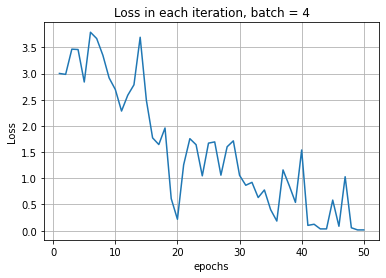

In [32]:
x_ax = np.linspace(1,len(L),len(L))
plt.figure()
plt.plot(x_ax,L)
plt.title("Loss in each iteration, batch = %s"%batch)
plt.ylabel("Loss",)
plt.xlabel("epochs")
plt.grid(True)
plt.show()

<Figure size 432x288 with 0 Axes>

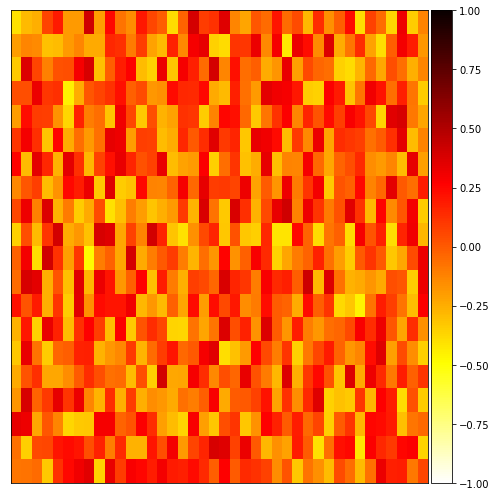

<Figure size 432x288 with 0 Axes>

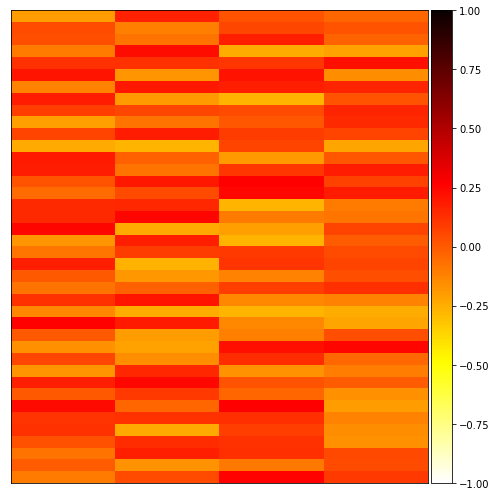

In [33]:
plt.figure()
plot_weights(forward_connection1.w,wmin=-1,figsize=[7,7])
plt.figure()
plot_weights(forward_connection2.w,wmin=-1,figsize=[7,7])
plt.show()


In [34]:
print(torch.max(forward_connection1.w))
print(torch.min(forward_connection1.w))
print(torch.max(forward_connection2.w))
print(torch.min(forward_connection2.w))
print("voltage threshold at the output layer ",network.layers["C"].thresh)
print("voltage threshold at the hidden layer ",network.layers["B"].thresh)

tensor(0.4176)
tensor(-0.4817)
tensor(0.2707)
tensor(-0.2729)
voltage threshold at the output layer  tensor([-64.4510, -64.4520, -64.4522, -64.4523])
voltage threshold at the hidden layer  tensor([-61.9016, -61.9037, -61.9017, -61.9016, -61.9001, -61.9016, -61.9012,
        -61.9016, -61.9016, -61.8974, -61.9018, -61.9016, -61.9016, -61.9016,
        -61.9016, -61.9016, -61.9016, -61.9035, -61.9019, -61.9032, -61.8990,
        -61.9056, -61.9016, -61.9016, -61.9027, -61.9016, -61.9024, -61.9016,
        -61.9003, -61.9017, -61.9016, -61.9016, -61.9016, -61.9017, -61.9024,
        -61.9036, -61.9025, -61.9029, -61.9016, -61.9016])


<Figure size 432x288 with 0 Axes>

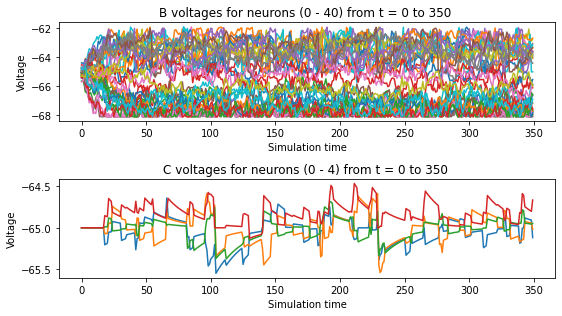

membrane voltage value before reset
tensor([[-65., -65., -65., -65., -65., -65., -65., -65., -65., -65., -65., -65.,
         -65., -65., -65., -65., -65., -65., -65., -65., -65., -65., -65., -65.,
         -65., -65., -65., -65., -65., -65., -65., -65., -65., -65., -65., -65.,
         -65., -65., -65., -65.]])
tensor([[-65., -65., -65., -65.]])


In [35]:
#plot the voltage 
plt.figure()
plot_voltages(voltages, plot_type="line")
plt.show()
print("membrane voltage value before reset")
print(network.layers["B"].v)
print(network.layers["C"].v)

In [36]:
print(forward_connection1.w)
print(torch.sum(torch.pow((forward_connection1.w),2),dim=0))

Parameter containing:
tensor([[-0.4060, -0.2891, -0.2533,  0.0689,  0.1892, -0.1940, -0.1946,  0.4127,
         -0.2087,  0.2477, -0.0716, -0.1555,  0.2006,  0.0564, -0.0138, -0.3832,
         -0.0289,  0.3960,  0.0876,  0.1249,  0.3613, -0.1271, -0.2203,  0.0129,
         -0.0545,  0.2052, -0.0527,  0.0393, -0.2803,  0.1332, -0.1632, -0.0107,
          0.2348, -0.3973,  0.0751, -0.0506, -0.3640,  0.3162, -0.3364, -0.1215],
        [-0.2014, -0.1276, -0.1477, -0.3111, -0.2900, -0.1934, -0.1274, -0.2403,
         -0.2347,  0.1559,  0.1254, -0.1009,  0.0899, -0.2171, -0.2883,  0.1663,
         -0.1392,  0.2935,  0.3390, -0.3519, -0.3862,  0.1145,  0.1020,  0.3209,
         -0.1404,  0.2899, -0.4220,  0.3205,  0.2273, -0.1425,  0.3692, -0.2477,
         -0.0792,  0.1330, -0.2130, -0.3923, -0.0154,  0.3017,  0.1843, -0.1867],
        [-0.3313,  0.3684,  0.0686, -0.1156,  0.0307,  0.0372,  0.2927,  0.3877,
         -0.3098, -0.0095,  0.1867,  0.2713, -0.2902, -0.3518,  0.3261, -0.3126,
    

In [38]:
print(forward_connection2.w)
print(torch.sum(torch.pow((forward_connection2.w),2),dim=0))

Parameter containing:
tensor([[-0.1955,  0.1700,  0.0214, -0.0365],
        [ 0.0412, -0.1144,  0.0566,  0.0185],
        [ 0.0374, -0.0718,  0.1733, -0.0296],
        [-0.0947,  0.2312, -0.2437, -0.2173],
        [ 0.1230,  0.1216,  0.1077,  0.2257],
        [ 0.2041, -0.1786,  0.2162, -0.1536],
        [-0.1250,  0.1980,  0.1793,  0.1631],
        [ 0.1813, -0.1906, -0.2673,  0.0205],
        [ 0.0813,  0.0601,  0.0424,  0.1626],
        [-0.2055, -0.0726,  0.0120,  0.1458],
        [ 0.0627,  0.1866,  0.0922,  0.0665],
        [-0.2351, -0.2681,  0.0661, -0.2197],
        [ 0.1928, -0.0159, -0.1897,  0.0135],
        [ 0.1866, -0.0719,  0.1052,  0.1846],
        [ 0.0174,  0.2002,  0.2707,  0.0735],
        [-0.0511,  0.0430,  0.2443,  0.1900],
        [ 0.1481,  0.1516, -0.2729, -0.0957],
        [ 0.1406,  0.2527, -0.0993, -0.0818],
        [ 0.2508, -0.2347, -0.2104,  0.0682],
        [-0.1747,  0.1775, -0.2665, -0.0021],
        [-0.0840,  0.0883,  0.0994,  0.0462],
        [ 0.